In [21]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("medexanon/Medex", split="train[:1%]")

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Total number of unique entities: 48348
Top 20 most frequent entities:
entity
glucose              2892
water                1765
ethanol              1709
nitric oxide         1526
sodium chloride      1415
ATP                  1265
cholesterol          1151
sucrose              1093
methanol             1061
glutathione          1020
glycerol             1015
EDTA                  916
calcium               859
arachidonic acid      855
hydrogen peroxide     850
Triton X-100          800
urea                  781
oxygen                777
NaCl                  758
acetic acid           730
Name: count, dtype: int64


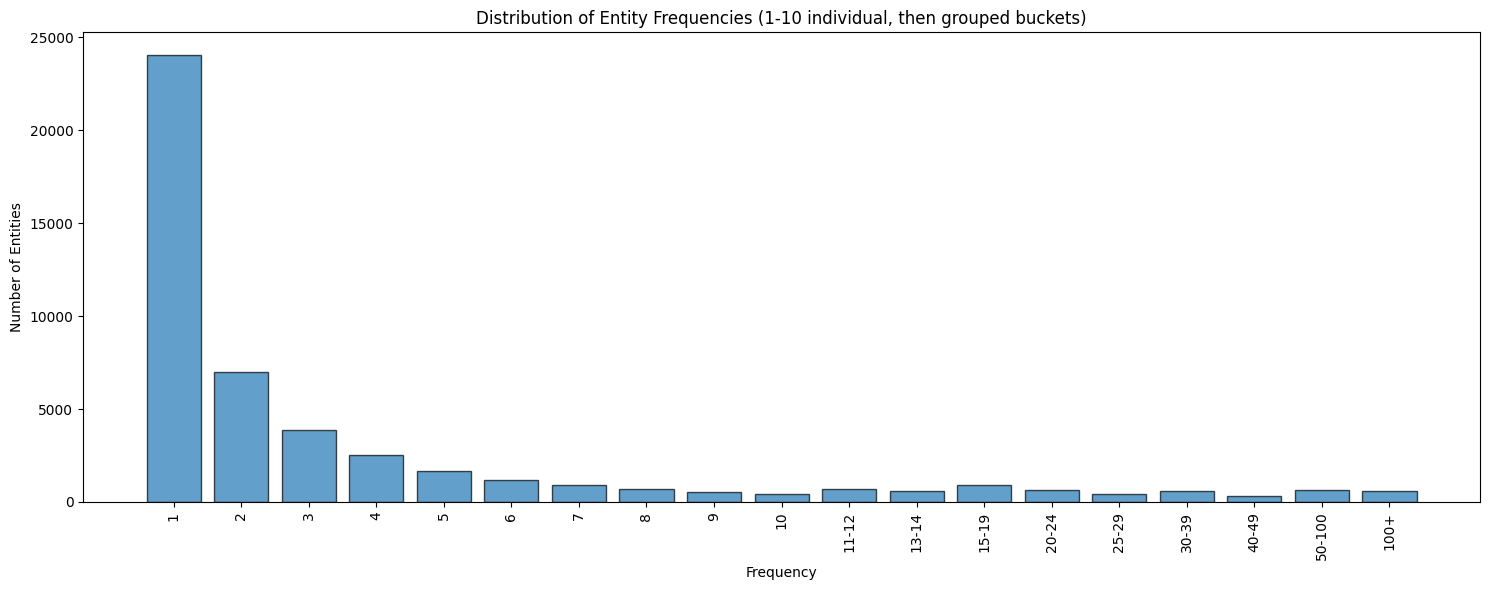


Frequency distribution:
1: 24069 entities
2: 7017 entities
3: 3880 entities
4: 2511 entities
5: 1670 entities
6: 1207 entities
7: 918 entities
8: 720 entities
9: 542 entities
10: 439 entities
11-12: 718 entities
13-14: 577 entities
15-19: 924 entities
20-24: 622 entities
25-29: 410 entities
30-39: 569 entities
40-49: 314 entities
50-100: 666 entities
100+: 575 entities


In [12]:
sub_ds = ds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert to pandas DataFrame for easier analysis
df = sub_ds.to_pandas()

# Get the counts of each entity
entity_counts = df['entity'].value_counts()

# Display all entity counts
print(f"Total number of unique entities: {len(entity_counts)}")
print("Top 20 most frequent entities:")
print(entity_counts.head(20))

# Create frequency buckets: 1-10 individually, then size 2, size 5, size 10 until 50+
freq_values = entity_counts.values
bucket_counts = []
labels = []

# Individual buckets for 1-10
for freq in range(1, 11):
    count = np.sum(freq_values == freq)
    bucket_counts.append(count)
    labels.append(str(freq))

# Size 2 buckets: 11-12, 13-14
for start in range(11, 15, 2):
    count = np.sum((freq_values >= start) & (freq_values <= start + 1))
    bucket_counts.append(count)
    labels.append(f"{start}-{start + 1}")

# Size 5 buckets: 15-19, 20-24, 25-29
for start in range(15, 30, 5):
    count = np.sum((freq_values >= start) & (freq_values <= start + 4))
    bucket_counts.append(count)
    labels.append(f"{start}-{start + 4}")

# Size 10 buckets: 30-39, 40-49
for start in range(30, 50, 10):
    count = np.sum((freq_values >= start) & (freq_values <= start + 9))
    bucket_counts.append(count)
    labels.append(f"{start}-{start + 9}")

# 50-100 bucket
count_50_to_100 = np.sum((freq_values >= 50) & (freq_values <= 100))
bucket_counts.append(count_50_to_100)
labels.append("50-100")

# Count entities with frequency > 100
count_100_plus = np.sum(freq_values > 100)
bucket_counts.append(count_100_plus)
labels.append("100+")

# Plot histogram of frequency buckets
plt.figure(figsize=(15, 6))
plt.bar(labels, bucket_counts, edgecolor='black', alpha=0.7)
plt.title('Distribution of Entity Frequencies (1-10 individual, then grouped buckets)')
plt.xlabel('Frequency')
plt.ylabel('Number of Entities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print bucket statistics
print("\nFrequency distribution:")
for label, count in zip(labels, bucket_counts):
    if count > 0:
        print(f"{label}: {count} entities")


Total number of unique entities: 16382
Top 20 most frequent entities:
entity
glucose              943
nitric oxide         627
ethanol              577
water                558
sodium chloride      514
ATP                  461
calcium              455
cholesterol          373
sucrose              347
methanol             338
glycerol             326
oxygen               326
EDTA                 323
urea                 309
Triton X-100         308
glutamate            300
hydrogen peroxide    300
NADPH                295
glutathione          286
acetylcholine        254
Name: count, dtype: int64


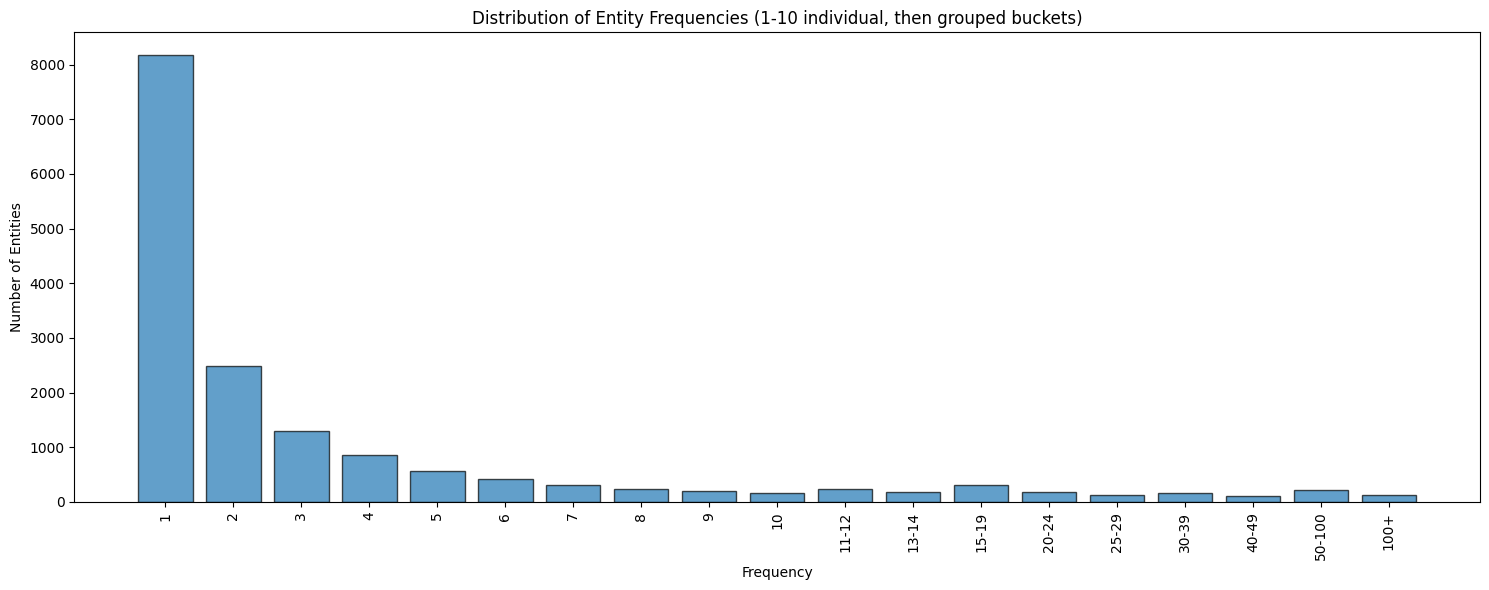


Frequency distribution:
1: 8181 entities
2: 2480 entities
3: 1299 entities
4: 851 entities
5: 573 entities
6: 420 entities
7: 319 entities
8: 243 entities
9: 201 entities
10: 160 entities
11-12: 236 entities
13-14: 184 entities
15-19: 319 entities
20-24: 177 entities
25-29: 135 entities
30-39: 164 entities
40-49: 102 entities
50-100: 210 entities
100+: 128 entities

Minimum bucket size: 102
Bucket 1: sampled 102 entities
Bucket 2: sampled 102 entities
Bucket 3: sampled 102 entities
Bucket 4: sampled 102 entities
Bucket 5: sampled 102 entities
Bucket 6: sampled 102 entities
Bucket 7: sampled 102 entities
Bucket 8: sampled 102 entities
Bucket 9: sampled 102 entities
Bucket 10: sampled 102 entities
Bucket 11-12: sampled 102 entities
Bucket 13-14: sampled 102 entities
Bucket 15-19: sampled 102 entities
Bucket 20-24: sampled 102 entities
Bucket 25-29: sampled 102 entities
Bucket 30-39: sampled 102 entities
Bucket 40-49: sampled 102 entities
Bucket 50-100: sampled 102 entities
Bucket 100+: 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert to pandas DataFrame for easier analysis

df = ds.select(range(100000)).to_pandas()

# Get the counts of each entity
entity_counts = df['entity'].value_counts()

# Display all entity counts
print(f"Total number of unique entities: {len(entity_counts)}")
print("Top 20 most frequent entities:")
print(entity_counts.head(20))

# Create frequency buckets: 1-10 individually, then size 2, size 5, size 10 until 50+
freq_values = entity_counts.values
bucket_counts = []
labels = []
bucket_entities = []

# Individual buckets for 1-10
for freq in range(1, 11):
    entities_in_bucket = entity_counts[entity_counts == freq].index.tolist()
    bucket_entities.append(entities_in_bucket)
    bucket_counts.append(len(entities_in_bucket))
    labels.append(str(freq))

# Size 2 buckets: 11-12, 13-14
for start in range(11, 15, 2):
    entities_in_bucket = entity_counts[(entity_counts >= start) & (entity_counts <= start + 1)].index.tolist()
    bucket_entities.append(entities_in_bucket)
    bucket_counts.append(len(entities_in_bucket))
    labels.append(f"{start}-{start + 1}")

# Size 5 buckets: 15-19, 20-24, 25-29
for start in range(15, 30, 5):
    entities_in_bucket = entity_counts[(entity_counts >= start) & (entity_counts <= start + 4)].index.tolist()
    bucket_entities.append(entities_in_bucket)
    bucket_counts.append(len(entities_in_bucket))
    labels.append(f"{start}-{start + 4}")

# Size 10 buckets: 30-39, 40-49
for start in range(30, 50, 10):
    entities_in_bucket = entity_counts[(entity_counts >= start) & (entity_counts <= start + 9)].index.tolist()
    bucket_entities.append(entities_in_bucket)
    bucket_counts.append(len(entities_in_bucket))
    labels.append(f"{start}-{start + 9}")

# 50-100 bucket
entities_50_to_100 = entity_counts[(entity_counts >= 50) & (entity_counts <= 100)].index.tolist()
bucket_entities.append(entities_50_to_100)
bucket_counts.append(len(entities_50_to_100))
labels.append("50-100")

# Count entities with frequency > 100
entities_100_plus = entity_counts[entity_counts > 100].index.tolist()
bucket_entities.append(entities_100_plus)
bucket_counts.append(len(entities_100_plus))
labels.append("100+")

# Plot histogram of frequency buckets
plt.figure(figsize=(15, 6))
plt.bar(labels, bucket_counts, edgecolor='black', alpha=0.7)
plt.title('Distribution of Entity Frequencies (1-10 individual, then grouped buckets)')
plt.xlabel('Frequency')
plt.ylabel('Number of Entities')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print bucket statistics
print("\nFrequency distribution:")
for label, count in zip(labels, bucket_counts):
    if count > 0:
        print(f"{label}: {count} entities")

# Create balanced dataset with equal representation from each bucket
np.random.seed(42)

# Find minimum bucket size (excluding empty buckets)
non_empty_bucket_counts = [count for count in bucket_counts if count > 0]
min_bucket_size = min(non_empty_bucket_counts)
print(f"\nMinimum bucket size: {min_bucket_size}")

# Sample entities from each bucket
balanced_entities = []
for i, (label, entities_in_bucket) in enumerate(zip(labels, bucket_entities)):
    if len(entities_in_bucket) > 0:
        if len(entities_in_bucket) >= min_bucket_size:
            sampled_entities = np.random.choice(entities_in_bucket, size=min_bucket_size, replace=False).tolist()
        else:
            sampled_entities = entities_in_bucket
        balanced_entities.extend(sampled_entities)
        print(f"Bucket {label}: sampled {len(sampled_entities)} entities")

# Create balanced dataset
balanced_df = df[df['entity'].isin(balanced_entities)]
print(f"\nBalanced dataset size: {len(balanced_df)} examples")
print(f"Number of unique entities: {balanced_df['entity'].nunique()}")

# Convert back to dataset format if needed
from datasets import Dataset
balanced_ds = Dataset.from_pandas(balanced_df)


,PMID,DOI,entity,fact,MolInfo,GeneInfo,ISSN,eISSN,Journal
4,1,10.1016/0006-2944(75)90147-7,methanol,Methanol toxicity in humans and lower animals ...,{'SMILES': 'CO'},None,0006-2944,None,Biochemical medicine
5,1,10.1016/0006-2944(75)90147-7,formaldehyde,The disposition of formaldehyde in animals has...,{'SMILES': 'C=O'},None,0006-2944,None,Biochemical medicine
10,1,10.1016/0006-2944(75)90147-7,phosphate,Phosphate buffer at 100 mM is used as the incu...,{'SMILES': 'O=P([O-])([O-])[O-]'},None,0006-2944,None,Biochemical medicine
11,1,10.1016/0006-2944(75)90147-7,sodium hydroxide,"Sodium hydroxide, in combination with zinc sul...",{'SMILES': '[Na+].[OH-]'},None,0006-2944,None,Biochemical medicine
12,1,10.1016/0006-2944(75)90147-7,zinc sulfate,"Zinc sulfate, when combined with sodium hydrox...",{'SMILES': 'O=S(=O)([O-])[O-].[Zn+2]'},None,0006-2944,None,Biochemical medicine
...,...,...,...,...,...,...,...,...,...
99985,10072447,None,glutaraldehyde,Glutaraldehyde is used at 2% (v/v) concentrati...,{'SMILES': 'O=CCCCC=O'},None,1076-1551,1528-3658,"Molecular medicine (Cambridge, Mass.)"
99988,10072450,10.1007/s100169900230,polytetrafluoroethylene,Polytetrafluoroethylene is used as a material ...,{'SMILES': 'FC(F)(C(F)(F)[*:2])[*:1]'},None,0890-5096,None,Annals of vascular surgery
99990,10072451,10.1007/s100169900231,thromboxane B2,Thromboxane B2 is used as a radiolabeled subst...,{'SMILES': 'CCCCC[C@H](O)/C=C/[C@H]1OC(O)C[C@H...,None,0890-5096,None,Annals of vascular surgery
99996,10072452,10.1007/s100169900232,polytetrafluoroethylene,Polytetrafluoroethylene (PTFE) grafts can achi...,{'SMILES': 'FC(F)(C(F)(F)[*:2])[*:1]'},None,0890-5096,None,Annals of vascular surgery


### Exploration

In [14]:
# Convert to pandas DataFrame for easier analysis
df = sub_ds.to_pandas()

# Get the counts of each entity
entity_counts = df['entity'].value_counts()
# Print entities with counts from 6-10
entities_6_to_10 = entity_counts[(entity_counts >= 2) & (entity_counts <= 4)]
print(f"\nEntities with counts from 6-10 ({len(entities_6_to_10)} total):")
for i, (entity, count) in enumerate(entities_6_to_10.items()):
    if i >= 10:
        break
    print(f"\n{entity}: {count} occurrences")
    entity_facts = df[df['entity'] == entity]['fact'].tolist()
    for j, fact in enumerate(entity_facts, 1):
        print(f"  {j}. {fact}")



Entities with counts from 6-10 (13408 total):

adipohydrazide: 4 occurrences
  1. The number of active hydrazide sites on poly(HEMA-co-EDMA) particles decreases from 27.5 to 0.5 µmol/g as the amount of adipohydrazide added to the reaction is reduced from 400 mg to 12.2 mg.
  2. Adipohydrazide is used to activate poly(HEMA-co-EDMA) carriers by reacting with the carrier material.
  3. Adipohydrazide is used to react with activated poly(HEMA-co-EDMA) particles functionalized with 2,4,6-trichloro-1,3,5-triazine to introduce hydrazide groups.
  4. Adipohydrazide is used to modify poly(HEMA-co-EDMA) particles to produce dihydrazide supports for glycoprotein immobilization.

trans-1,4-bis[[1-cyclohexyl-3-(4-dimethylamino phenyl) ureido]methyl]cyclohexane: 4 occurrences
  1. trans-1,4-bis[[1-cyclohexyl-3-(4-dimethylamino phenyl) ureido]methyl]cyclohexane (NTE-122) is a novel acyl-CoA:cholesterol acyltransferase (ACAT) inhibitor.
  2. trans-1,4-bis[[1-cyclohexyl-3-(4-dimethylamino phenyl) urei

In [16]:
# Convert to pandas DataFrame for easier analysis
df = sub_ds.to_pandas()

# Get the counts of each entity
entity_counts = df['entity'].value_counts()
# Print entities with counts from 25-50
entities_25_to_50 = entity_counts[(entity_counts >= 25) & (entity_counts <= 30)]
print(f"\nEntities with counts from 25-50 ({len(entities_25_to_50)} total):")
for i, (entity, count) in enumerate(entities_25_to_50.items()):
    if i >= 10:
        break
    print(f"\n{entity}: {count} occurrences")
    entity_facts = df[df['entity'] == entity]['fact'].tolist()
    for j, fact in enumerate(entity_facts, 1):
        print(f"  {j}. {fact}")



Entities with counts from 25-50 (485 total):

calcium dobesilate: 30 occurrences
  1. Calcium dobesilate (Doxium) treatment in pregnant women with mild to moderate midtrimester hypertension leads to a reduction in mean arterial pressure from 118 ± 7 to 99 ± 9 mm Hg over 53–57 days.
  2. Calcium dobesilate (Doxium) administration in pregnancy is associated with a significant decrease in plasma fibronectin levels (23.8 vs. 9.4% reduction in treated vs. placebo groups, respectively) and a favorable effect on platelet count, plasma viscosity, and erythrocyte deformability.
  3. Calcium dobesilate (Doxium) appears to reduce the need for medication and hospitalisation in cases of mild to moderate midtrimester hypertension.
  4. Calcium dobesilate is a therapeutic agent with antioxidative and vasoprotective properties that has been used successfully for treating diabetic retinopathy and chronic venous insufficiency.
  5. Calcium dobesilate significantly reduces microvascular permeability as 

In [8]:
# Convert to pandas DataFrame for easier analysis
df = sub_ds.to_pandas()

# Get the counts of each entity
entity_counts = df['entity'].value_counts()
# Print entities with counts 100+
entities_100_plus = entity_counts[entity_counts >= 100]
print(f"\nEntities with counts 100+ ({len(entities_100_plus)} total):")
for entity, count in entities_100_plus.items():
    print(f"\n{entity}: {count} occurrences")
    entity_facts = df[df['entity'] == entity]['fact'].tolist()
    for i, fact in enumerate(entity_facts, 1):
        print(f"  {i}. {fact}")



Entities with counts 100+ (2 total):

calcium: 169 occurrences
  1. Calcium can overcome the inhibitory effect of magnesium on the acrosome reaction in guinea pig spermatozoa in vitro, with 3 or 5 mM calcium sufficient to restore acrosome reaction activity in the presence of 1 mM magnesium.
  2. In growing rats fed a low-phosphorous diet adequate in vitamin-D3, mucosal calcium concentration increases in parallel with duodenal calcium-binding protein and fractional calcium absorption.
  3. Ionized calcium is liberated and rebound during the contractile cycle of myocardial cells, and its interaction with a myocardial receptor site may be correlated with the positive inotropic effect of digitalis.
  4. Increased availability of calcium at active sodium (NA) releasing sites in the axon leads to decreased inhibition of NA release by prostaglandin E2.
  5. Increased calcium entry into the axon during the nerve action potential is implicated in the mechanisms of enhanced transmitter release 

### Create Knowledge Probes

Identify target span
1. We import a set of common stop words
2. We ask the LLM to add more stop words
2. We ask the LLM to identify stop words that separates the information that exist at the end of the fact.

In [43]:
import sys
sys.path.append("../../")
import utils.utils as utils
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already available
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# 1. Import common stop words
common_stopwords = set(stopwords.words('english'))
print(f"Common stopwords count: {len(common_stopwords)}")

# 2. Ask LLM to add more stop words
additional_stopwords = ["a", "an", "the", "and", "or", "but", "in", "on", "at", "to", "for", "of", "with", "by", "from", "up", "about", "into", "through", "during", "before", "after", "above", "below", "between", "among", "under", "over", "against", "across", "around", "behind", "beside", "beneath", "beyond", "inside", "outside", "upon", "within", "without", "toward", "towards", "regarding", "concerning", "including", "excluding", "despite", "although", "however", "nevertheless", "therefore", "thus", "hence", "moreover", "furthermore", "additionally", "consequently", "subsequently", "meanwhile", "otherwise", "instead", "rather", "quite", "very", "much", "many", "most", "some", "any", "all", "each", "every", "both", "either", "neither", "none", "few", "several", "various", "different", "same", "such", "like", "as", "than", "so", "too", "also", "even", "only", "just", "still", "yet", "already", "now", "then", "here", "there", "where", "when", "why", "how", "what", "which", "who", "whom", "whose", "that", "this", "these", "those", "it", "its", "they", "them", "their", "theirs", "he", "him", "his", "she", "her", "hers", "we", "us", "our", "ours", "you", "your", "yours", "i", "me", "my", "mine"]
print(f"Additional stopwords from LLM: {len(additional_stopwords)}")

# Combine stopwords so far
print(f"Len of common stopwords: {len(common_stopwords)}")
print(f"Len of additional stopwords from LLM: {len(additional_stopwords)}")
all_stopwords = common_stopwords.union(additional_stopwords)
print(f"Total stopwords after union: {len(all_stopwords)}")

Common stopwords count: 198
Additional stopwords from LLM: 134
Len of common stopwords: 198
Len of additional stopwords from LLM: 134
Total stopwords after union: 251


In [46]:
# 3. Ask LLM to identify separator words from actual facts
# Get 100 sample facts from balanced_ds
sample_facts = [balanced_ds[i]['fact'] for i in range(100)]

# Format the sample facts for the prompt
formatted_facts = "\n".join([f"{i+1}. {fact}" for i, fact in enumerate(sample_facts)])
prompt = {}
prompt['system'] = """You are an expert linguist specializing in scientific text analysis. Your task is to identify separator words or phrases that commonly precede key *ending* information in scientific facts."""
prompt['user'] = f"""# Task
Identify plain English words or phrases that commonly separate or precede the key information at the end of each scientific fact. These separator words will help identify where target information begins and should be single words or phrases that serve as stop words.

## Examples

### Example 1
**Fact:** Methanol toxicity in humans and lower animals is associated with the oxidation of methanol, a process that involves formic acid as a metabolite.
**Separator:** "as a"

### Example 2  
**Fact:** The disposition of formaldehyde in animals has been studied, contributing to our understanding of its metabolic pathways.
**Separator:** "its"

### Example 3
**Fact:** Phosphate buffer at 100 mM is used as the incubation medium for both diaphorase and coupled enzyme assays.
**Separator:** "and"

### Example 4
**Fact:** Sodium hydroxide, in combination with zinc sulfate, is more effective than perchloric acid for protein precipitation from blood.
**Separator:** "from"

### Example 5
**Fact:** Zinc sulfate, when combined with sodium hydroxide, is more effective than perchloric acid for protein precipitation from blood and removes inhibitory substances and interfering pigments retained after perchloric acid treatment.
**Separator:** "after"

### Example 6
**Fact:** Sodium hydroxide is used in a protein precipitation method with zinc sulfate for the recovery of formate from blood samples.
**Separator:** "from"

### Example 7
**Fact:** Trichloroacetic acid is inhibitory to the coupled reaction for formate determination and acts competitively with formate.
**Separator:** "with"

### Example 8
**Fact:** Methanol poisoning in monkeys can be monitored by measuring blood formic acid levels using a formate dehydrogenase-based enzymatic assay.
**Separator:** "a"

### Example 9
**Fact:** Dithiothreitol at 0.1 mM helps stabilize crude enzyme preparations, maintaining about 100% enzymatic activity at -80°C for at least 6 months.
**Separator:** "least"

## Facts to Analyze
{formatted_facts}

## Output Format
Provide only the separator words/phrases as a comma-separated list."""
# Analyze separator words across multiple rounds
for round_num in range(1, 7):
    start_idx = (round_num - 1) * 100
    end_idx = round_num * 100
    
    sample_facts = [balanced_ds[i]['fact'] for i in range(start_idx, end_idx)]
    formatted_facts = "\n".join([f"{i+1}. {fact}" for i, fact in enumerate(sample_facts)])
    
    # Update the prompt with new facts
    prompt['user'] = prompt['user'].format(formatted_facts=formatted_facts)
    
    separator_response = utils.query_llm(prompt, model="gpt-4.1", system_prompt_included=True)
    separator_words = set([word.strip().lower() for word in separator_response.split(',')])
    
    print(f"Round {round_num} - Separator words from LLM: {len(separator_words)}")
    print(f"Round {round_num} - Stopwords: {sorted(list(separator_words))}")
    
    all_stopwords = all_stopwords.union(separator_words)
    print(f"Round {round_num} - Total stopwords and separators: {len(all_stopwords)}\n")

print(f"\nFinal analysis summary:")
print(f"Analyzed {600} facts across 6 rounds")
print(f"Final total stopwords and separators: {len(all_stopwords)}")

Round 1 - Separator words from LLM: 26
Round 1 - Stopwords: ['about', 'after', 'among', 'and', 'as a', 'at', 'between', 'by', 'during', 'for', 'from', 'in', 'into', 'is', 'its', 'of', 'on', 'or', 'than', 'that', 'to', 'under', 'using', 'when', 'which', 'with']
Round 1 - Total stopwords and separators: 253

Round 2 - Separator words from LLM: 78
Round 2 - Stopwords: ['acts', 'added to', 'after', 'allowing', 'and', 'are', 'as a', 'at', 'be', 'between', 'by', 'can', 'coinciding with', 'combined with', 'compared to', 'compared with', 'comprising', 'consisting of', 'containing', 'contributing to', 'during', 'enabling', 'facilitating', 'for', 'from', 'had', 'has', 'have', 'helps', 'higher than', 'in', 'included in', 'including', 'indicating', 'is', 'its', 'leading to', 'lower than', 'maintaining', 'may', 'measured in', 'necessary for', 'observed after', 'observed among', 'observed as', 'observed at', 'observed between', 'observed by', 'observed during', 'observed for', 'observed from', 'obse

In [47]:
all_stopwords.remove('')
print(len(all_stopwords))

304


In [121]:
def split_fact_by_stopwords(example):
    """
    Split fact by the last appearing stopword into probe and target.
    Returns the original example with added fact_probe and fact_target columns.
    """
    fact = example.get("fact", "")
    fact = fact if (fact.endswith('.') or fact.endswith("'")) else fact + '.'

    if not fact:
        example["fact_probe"] = None
        example["fact_target"] = None
        return example
    
    # Find all stopword positions in the fact
    words = fact.split()
    stopword_positions = []
    
    for i, word in enumerate(words):
        # Remove punctuation for comparison
        clean_word = word.lower().strip('.,!?;:"()[]{}')
        if clean_word in all_stopwords:
            stopword_positions.append(i)
    
    if not stopword_positions:
        example["fact_probe"] = None
        example["fact_target"] = None
        return example
    
    # Split at the last stopword position
    last_stopword_idx = stopword_positions[-1]
    
    # Probe: everything up to and including the stopword
    probe_words = words[:last_stopword_idx + 1]
    fact_probe = " ".join(probe_words)
    
    # Target: everything after the stopword
    target_words = words[last_stopword_idx + 1:]
    
    if len(target_words) > 10:
        print(f"Warning: Target has {len(target_words)} words, setting to None: {fact}")
        example["fact_probe"] = None
        example["fact_target"] = None
        return example
    
    fact_target = " " + " ".join(target_words) if target_words else ""
    
    example["fact_probe"] = fact_probe
    example["fact_target"] = fact_target
    return example

# Apply the splitting function to add new columns
balanced_ds = balanced_ds.map(split_fact_by_stopwords)

# Count successful splits
valid_probes = sum(1 for example in balanced_ds if example['fact_probe'] is not None)
print(f"Successfully split {valid_probes} facts out of {len(balanced_ds)} total facts")


Map:   0%|          | 0/49559 [00:00<?, ? examples/s]

Successfully split 49559 facts out of 49559 total facts


In [122]:
# Drop rows with None in 'fact_target' or 'fact_probe'
balanced_ds = balanced_ds.filter(lambda example: example['fact_probe'] is not None and example['fact_target'] is not None)
print(f"After filtering: {len(balanced_ds)} examples remain")


Filter:   0%|          | 0/49559 [00:00<?, ? examples/s]

After filtering: 49559 examples remain


In [126]:
balanced_ds[2967]

{'PMID': '1001399',
 'DOI': '10.1016/0014-4886(76)90156-4',
 'entity': '5-hydroxytryptamine',
 'fact': "5-hydroxytryptamine is a monoamine whose nerve terminals in the brain undergo reduced density after neonatal 5,7-dihydroxytryptamine treatment, due to a 'pruning effect.'",
 'MolInfo': {'SMILES': 'NCCc1c[nH]c2ccc(O)cc12'},
 'GeneInfo': None,
 'ISSN': '0014-4886',
 'eISSN': None,
 'Journal': 'Experimental neurology',
 '__index_level_0__': 5219,
 'fact_probe': '5-hydroxytryptamine is a monoamine whose nerve terminals in the brain undergo reduced density after neonatal 5,7-dihydroxytryptamine treatment, due to a',
 'fact_target': " 'pruning effect.'"}

Now we create the training text, the probe with context, the probe with minimal context

In [127]:

def create_probe_text(example):
    """
    Combine entity, SMILES, and fact into a minimal, structured string for LLM training.
    The order is Entity, SMILES, then Fact.
    Also extracts the fact and entity separately and creates various probe formats.
    """
    chunks = []
    
    entity = example.get("entity")
    fact_text = " " + example.get("fact", "")
    fact_probe = " " + example.get("fact_probe", "")
    fact_target = " " + example.get("fact_target", "")

    # 1. Entity
    if entity:
        chunks.append(f"Entity: {entity}")

    # 2. SMILES
    if (mol := example.get("MolInfo")) and isinstance(mol, dict):
        if smiles := mol.get("SMILES"):
            chunks.append(f"SMILES: '{smiles}'")

    # 3. Fact
    if fact_text:
        chunks.append(f"Fact:{fact_text}")
    
    # Join with ". ". We already ensure the fact has a period at the end.
    full_text = ". ".join(chunks)

    # Create additional probe formats
    # Full context probe: Entity + SMILES + fact_probe
    full_context_chunks = []
    if entity:
        full_context_chunks.append(f"Entity: {entity}")
    if (mol := example.get("MolInfo")) and isinstance(mol, dict):
        if smiles := mol.get("SMILES"):
            full_context_chunks.append(f"SMILES: '{smiles}'")
    if fact_probe:
        full_context_chunks.append(f"Fact:{fact_probe}")
    
    full_context_probe = ". ".join(full_context_chunks).rstrip()

    # Minimal context probe: Entity + fact_probe
    minimal_context_chunks = []
    if entity:
        minimal_context_chunks.append(f"Entity: {entity}")
    if fact_probe:
        minimal_context_chunks.append(f"Fact:{fact_probe}")
    
    minimal_context_probe = ". ".join(minimal_context_chunks).rstrip()

    # Full context whole fact probe: Entity + SMILES + full fact
    full_context_whole_fact_chunks = []
    if entity:
        full_context_whole_fact_chunks.append(f"Entity: {entity}")
    if (mol := example.get("MolInfo")) and isinstance(mol, dict):
        if smiles := mol.get("SMILES"):
            full_context_whole_fact_chunks.append(f"SMILES: '{smiles}'")
    if fact_text:
        full_context_whole_fact_chunks.append("Fact:")
    
    full_context_whole_fact_probe = ". ".join(full_context_whole_fact_chunks).rstrip()

    # Minimal context: just entity information
    minimal_context = f"Entity: {entity}. Fact:" if entity else ""

    # Minimal text: entity information and entire fact
    minimal_text_chunks = []
    if entity:
        minimal_text_chunks.append(f"Entity: {entity}")
    if fact_text:
        minimal_text_chunks.append(f"Fact:{fact_text}")
    
    minimal_text = ". ".join(minimal_text_chunks)

    # Count digits in fact_target
    digit_count = sum(1 for char in fact_target if char.isdigit())

    return {
        "text": full_text,
        "fact": fact_text,
        "entity": entity,
        "full_context_probe": full_context_probe,
        "minimal_context_probe": minimal_context_probe,
        "full_context": full_context_whole_fact_probe,
        "minimal_context": minimal_context,
        "minimal_text": minimal_text,
        "fact_target_digit_count": digit_count
    }

# Apply the function to create the probe columns
probes_ds = balanced_ds.map(
    create_probe_text,
    remove_columns=ds.column_names,
    desc="Creating knowledge probes"
)
# drop column '__index_level_0__' from probes_ds
probes_ds = probes_ds.remove_columns(['__index_level_0__'])
probes_ds.to_csv(f"../../data/MEDEX/knowledge_probes_balanced_{len(balanced_ds)}.csv", index=False)


Creating knowledge probes:   0%|          | 0/49559 [00:00<?, ? examples/s]

Creating CSV from Arrow format:   0%|          | 0/50 [00:00<?, ?ba/s]

58592820

In [132]:
from transformers import AutoTokenizer
import tqdm
import os

# It's good practice to disable parallelism in notebooks to avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

def show_string_diff(str1, str2, label1, label2):
    """Show where two strings differ by highlighting the first difference."""
    min_len = min(len(str1), len(str2))
    diff_pos = None
    
    for i in range(min_len):
        if str1[i] != str2[i]:
            diff_pos = i
            break
    
    if diff_pos is None and len(str1) != len(str2):
        diff_pos = min_len
    
    if diff_pos is not None:
        char1 = str1[diff_pos] if diff_pos < len(str1) else "EOF"
        char2 = str2[diff_pos] if diff_pos < len(str2) else "EOF"
        print(f"Reconstr Text: '{str1[:diff_pos]}[{char1}]{str1[diff_pos+1:diff_pos+11]}...'")
        print(f"Original Text: '{str2[:diff_pos]}[{char2}]{str2[diff_pos+1:diff_pos+11]}...'")
        print(f"First difference at position {diff_pos}: '{char1}' vs '{char2}'")
    else:
        print("Strings are identical")

def verify_probe(example):
    """
    Verifies that the different text/probe/context combinations are constructed correctly.
    Specifically, it checks that:
    1. tokenize(probe + target) == tokenize(full_text)
    2. The probe's tokens are a continuous prefix of the full_text's tokens.
    3. tokenize(context + fact + "'." ) == tokenize(full_text)
    4. The context's tokens are a continuous prefix of the full_text's tokens.
    """
    entity = example['entity']

    # --- Minimal Context Probe Verification ---
    reconstructed_minimal_text = example['minimal_context_probe'] + example['fact_target']
    tokens_reconstructed_minimal = tokenizer.encode(reconstructed_minimal_text, add_special_tokens=False)
    tokens_minimal_text = tokenizer.encode(example['minimal_text'], add_special_tokens=False)
    
    if not (tokens_reconstructed_minimal == tokens_minimal_text):
        # print("--- Minimal text (from probe) reconstruction failed ---")
        # print(f"Entity: {entity}")
        # show_string_diff(reconstructed_minimal_text, example['minimal_text'], 
        #                 "Reconstructed text", "Original text")
        # print(f"Reconstructed tokens: {tokens_reconstructed_minimal}")
        # print(f"Original tokens:      {tokens_minimal_text}")
        # assert False, f"Minimal text (from probe) reconstruction failed for entity: {entity}"
        return False

    tokens_minimal_probe = tokenizer.encode(example['minimal_context_probe'], add_special_tokens=False)
    if not (tokens_minimal_text[:len(tokens_minimal_probe)] == tokens_minimal_probe):
        # print("--- Minimal probe is not a prefix of minimal text ---")
        # print(f"Entity: {entity}")
        # print(f"Probe text:   '{example['minimal_context_probe']}'")
        # print(f"Original text: '{example['minimal_text']}'")
        # print(f"Probe tokens: {tokens_minimal_probe}")
        # print(f"Prefix of original tokens: {tokens_minimal_text[:len(tokens_minimal_probe)]}")
        # assert False, f"Minimal probe is not a prefix of minimal text for entity: {entity}"
        return False

    # --- Full Context Probe Verification ---
    reconstructed_full_text = example['full_context_probe'] + example['fact_target']
    tokens_reconstructed_full = tokenizer.encode(reconstructed_full_text, add_special_tokens=False)
    tokens_full_text = tokenizer.encode(example['text'], add_special_tokens=False)
    
    if not (tokens_reconstructed_full == tokens_full_text):
        # print("--- Full text (from probe) reconstruction failed ---")
        # print(f"Entity: {entity}")
        # show_string_diff(reconstructed_full_text, example['text'], 
        #                 "Reconstructed text", "Original text")
        # print(f"Reconstructed tokens: {tokens_reconstructed_full}")
        # print(f"Original tokens:      {tokens_full_text}")
        # assert False, f"Full text (from probe) reconstruction failed for entity: {entity}"
        return False

    tokens_full_probe = tokenizer.encode(example['full_context_probe'], add_special_tokens=False)
    if not (tokens_full_text[:len(tokens_full_probe)] == tokens_full_probe):
        # print("--- Full probe is not a prefix of full text ---")
        # print(f"Entity: {entity}")
        # print(f"Probe text:   '{example['full_context_probe']}'")
        # print(f"Original text: '{example['text']}'")
        # print(f"Probe tokens: {tokens_full_probe}")
        # print(f"Prefix of original tokens: {tokens_full_text[:len(tokens_full_probe)]}")
        # assert False, f"Full probe is not a prefix of full text for entity: {entity}"
        return False

    # --- Minimal Context + Fact Verification ---
    reconstructed_minimal_from_context = f"{example['minimal_context']}{example['fact']}"
    tokens_reconstructed_minimal_from_context = tokenizer.encode(reconstructed_minimal_from_context, add_special_tokens=False)
    if not (tokens_reconstructed_minimal_from_context == tokens_minimal_text):
        # print("--- Minimal text (from context) reconstruction failed ---")
        # print(f"Entity: {entity}")
        # show_string_diff(reconstructed_minimal_from_context, example['minimal_text'], 
        #                 "Reconstructed text", "Original text")
        # print(f"Reconstructed tokens: {tokens_reconstructed_minimal_from_context}")
        # print(f"Original tokens:      {tokens_minimal_text}")
        # assert False, f"Minimal text (from context) reconstruction failed for entity: {entity}"
        return False

    tokens_minimal_context = tokenizer.encode(example['minimal_context'], add_special_tokens=False)
    if not (tokens_minimal_text[:len(tokens_minimal_context)] == tokens_minimal_context):
        # print("--- Minimal context is not a prefix of minimal text ---")
        # print(f"Entity: {entity}")
        # print(f"Context text:  '{example['minimal_context']}'")
        # print(f"Original text: '{example['minimal_text']}'")
        # print(f"Context tokens: {tokens_minimal_context}")
        # print(f"Prefix of original tokens: {tokens_minimal_text[:len(tokens_minimal_context)]}")
        # assert False, f"Minimal context is not a prefix of minimal text for entity: {entity}"
        return False

    # --- Full Context + Fact Verification ---
    reconstructed_full_from_context = f"{example['full_context']}{example['fact']}"
    tokens_reconstructed_full_from_context = tokenizer.encode(reconstructed_full_from_context, add_special_tokens=False)
    if not (tokens_reconstructed_full_from_context == tokens_full_text):
        # print("--- Full text (from context) reconstruction failed ---")
        # print(f"Entity: {entity}")
        # show_string_diff(reconstructed_full_from_context, example['text'], 
        #                 "Reconstructed text", "Original text")
        # print(f"Reconstructed tokens: {tokens_reconstructed_full_from_context}")
        # print(f"Original tokens:      {tokens_full_text}")
        # assert False, f"Full text (from context) reconstruction failed for entity: {entity}"
        return False

    tokens_full_context = tokenizer.encode(example['full_context'], add_special_tokens=False)
    if not (tokens_full_text[:len(tokens_full_context)] == tokens_full_context):
        # print("--- Full context is not a prefix of full text ---")
        # print(f"Entity: {entity}")
        # print(f"Context text:  '{example['full_context']}'")
        # print(f"Original text: '{example['text']}'")
        # print(f"Context tokens: {tokens_full_context}")
        # print(f"Prefix of original tokens: {tokens_full_text[:len(tokens_full_context)]}")
        # assert False, f"Full context is not a prefix of full text for entity: {entity}"
        return False

    return True


# Verify probes and filter out failing ones
valid_examples = []
failed_count = 0

for ex in tqdm.tqdm(probes_ds, desc="Verifying all probes"):
    if verify_probe(ex):
        valid_examples.append(ex)
    else:
        failed_count += 1

print(f"✅ Verification complete: {len(valid_examples)} probes passed, {failed_count} probes failed")

# Create new dataset with only valid examples
from datasets import Dataset
probes_ds = Dataset.from_list(valid_examples)

# Clean up environment variable
del os.environ["TOKENIZERS_PARALLELISM"]


Verifying all probes: 100%|██████████| 49559/49559 [00:47<00:00, 1043.10it/s]


✅ Verification complete: 49558 probes passed, 1 probes failed


In [133]:
print(probes_ds)

Dataset({
    features: ['entity', 'fact', 'fact_probe', 'fact_target', 'text', 'full_context_probe', 'minimal_context_probe', 'full_context', 'minimal_context', 'minimal_text', 'fact_target_digit_count'],
    num_rows: 49558
})


In [134]:
from transformers import AutoTokenizer

# Load OLMO2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B")

# Function to count tokens in text
def count_tokens(text):
    return len(tokenizer.encode(text, add_special_tokens=False))

# Apply tokenization to get token counts
token_counts = [count_tokens(example['text']) for example in probes_ds]

# Find the maximum length
max_length = max(token_counts)

print(f"Token count statistics:")
print(f"Min tokens: {min(token_counts)}")
print(f"Max tokens: {max_length}")
print(f"Average tokens: {sum(token_counts) / len(token_counts):.2f}")

# Show distribution
import numpy as np
print(f"Median tokens: {np.median(token_counts)}")
print(f"95th percentile: {np.percentile(token_counts, 95):.0f}")


Token count statistics:
Min tokens: 17
Max tokens: 985
Average tokens: 79.59
Median tokens: 66.0
95th percentile: 159


In [103]:
probes_ds[0]

{'entity': 'methanol',
 'fact': 'Methanol toxicity in humans and lower animals is associated with the oxidation of methanol, a process that involves formic acid as a metabolite.',
 'fact_probe': 'Methanol toxicity in humans and lower animals is associated with the oxidation of methanol, a process that involves formic acid as a',
 'fact_target': ' metabolite.',
 'text': "Entity: 'methanol'. SMILES: 'CO'. Fact: 'Methanol toxicity in humans and lower animals is associated with the oxidation of methanol, a process that involves formic acid as a metabolite.'.",
 'full_context_probe': "Entity: 'methanol'. SMILES: 'CO'. Fact: 'Methanol toxicity in humans and lower animals is associated with the oxidation of methanol, a process that involves formic acid as a",
 'minimal_context_probe': "Entity: 'methanol'. Fact: 'Methanol toxicity in humans and lower animals is associated with the oxidation of methanol, a process that involves formic acid as a",
 'full_context': "Entity: 'methanol'. SMILES: 'C

### Paraphrase medex


In [76]:
# Keep track of how many tokens I've used 
# Go through 5,000,000 tokens worth of data (in terms of input tokens) and create a new column called "paraphrased_fact_1" with gpt-4.1-mini 
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("medexanon/Medex", split="train[:1%]")
# Count unique rows by converting each row to a hashable format
unique_rows = set()
for row in ds:
    # Convert dict values to a hashable tuple, handling nested dicts/lists
    hashable_row = tuple(str(v) if isinstance(v, (dict, list)) else v for v in row.values())
    unique_rows.add(hashable_row)

print(f"Unique rows: {len(unique_rows)}")
print(f"Total rows: {len(ds)}")
print(f"Duplicate rows: {len(ds) - len(unique_rows)}")
print(len(ds.unique("fact")))

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Unique rows: 362893
Total rows: 363088
Duplicate rows: 195
362071
